In [95]:
import xarray as xr
# import matplotlib.pyplot as plt
import datetime
from glob import glob
import dask, dask.distributed
import dask_jobqueue
import matplotlib.pyplot as plt
import datetime
import numpy as np
# import parcels
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import cartopy.crs as ccrs
import cmocean
from xhistogram.xarray import histogram as xhist
import seawater as gsw
import matplotlib.colors as mcolors
import datetime as dt 

In [2]:
cluster = dask_jobqueue.SLURMCluster(

    # Dask worker size
    cores=4, memory='16GB',
    processes=1, # Dask workers per job
    
    # SLURM job script things
    queue='base', walltime='04:00:00',
    
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',  # for spilling tmp data to disk
    log_directory='slurm/' 
)

client = dask.distributed.Client(cluster)

cluster.scale(jobs=15) #15
client

<Client: 'tcp://172.18.4.21:41067' processes=0 threads=0, memory=0 B>

In [3]:
ds = xr.open_dataset('data/level2/parcels_releases_seed-2345.zarr', engine='zarr', chunks='auto')


In [4]:
# Find particles where salinity reaches 0 at any observation point
particles_reach_zero_salinity = (ds.salt == 0).any('obs')

particles_beached = ~particles_reach_zero_salinity

# Filter the dataset to include only particles that reach zero salinity
ds_particles_reach_zero_salinity_beached = ds.where(particles_beached, drop=False)
ds = ds_particles_reach_zero_salinity_beached

In [5]:
ds_density = xr.apply_ufunc(gsw.eos80.pden,ds.salt,ds.temp,0,dask='parallelized',output_dtypes=[np.float64]) - 1000

# assigning density to the ds!
ds_add_dens = ds.assign(sigma0=ds_density)
ds = ds_add_dens

In [6]:
import datetime as dt 


p=ds
p['start_time'] = p.isel(obs=0).time
p=p.set_coords('start_time')
p=p.set_xindex('start_time')


In [32]:
p

<xarray.Dataset>
Dimensions:     (trajectory: 497743, obs: 20075)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 ... 20069 20070 20071 20072 20073 20074
  * trajectory  (trajectory) int64 1 8 9 14 ... 3518721 3518723 3518726 3518727
  * start_time  (trajectory) datetime64[ns] NaT ... 2020-05-31T00:00:01
Data variables:
    age         (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    lat         (trajectory, obs) float64 dask.array<chunksize=(782, 15330), meta=np.ndarray>
    lon         (trajectory, obs) float64 dask.array<chunksize=(782, 15330), meta=np.ndarray>
    salt        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    temp        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(782, 15330), meta=np.ndarray>
    uvel        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    vvel        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    z           (trajectory, obs) float64 dask.array<chunksize=(782, 15330), meta=np.ndarray>
    sigma0      (trajectory, obs) float64 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

In [19]:
# for i in range(0, 100000, 100):
#     print(ds.isel(trajectory=i).start_time.values)


In [6]:
WEST = (ds.lon > -8) & (ds.lat > 62.5) & (ds.lon < -5) & (ds.lat < 64.5)
EAST = (ds.lon > 0) & (ds.lat < 64.5) & (ds.lon < 2.5) & (ds.lat > 62.5) 
EIC = (ds.lon > -15) & (ds.lat > 66.25) & (ds.lon < -11.95) & (ds.lat < 68.7)
Svinoy = (ds.lon < 5.5) & (ds.lat > 62.24) & (ds.lon > -1) & (ds.lat < 65) 
VP = (ds.lon < 7) & (ds.lat > 66) & (ds.lon > 0) & (ds.lat > 68) 


In [42]:
#p[['lat','lon','temp']].reindex_like(WEST).where(WEST, np.nan)
#ds

In [7]:
WEST_TS = ds[['salt','sigma0','temp','vvel', 'z']].where(WEST, np.nan)
EAST_TS = ds[['salt','sigma0','temp','vvel', 'z']].where(EAST, np.nan)
Svinoy_TS = ds[['salt','sigma0','temp','vvel', 'z']].where(Svinoy, np.nan)
VP_TS = ds[['salt','sigma0','temp','vvel', 'z']].where(VP, np.nan)

In [36]:
# # WEST_p = (p.lon > -8) & (p.lat > 62.5) & (p.lon < -5) & (p.lat < 64.5)
# WEST_p = p.sel(lon=slice(-8, -5), lat=slice(62.5, 64.5))

In [77]:
WEST_TS_dense = WEST_TS.where(WEST_TS.sigma0 > 27.8, drop=False)

In [50]:
T_WEST_cp = WEST_TS.temp.mean(dim='obs').compute()
S_WEST_cp = WEST_TS.salt.mean(dim='obs').compute()
sigma0_WEST_cp = WEST_TS.sigma0.mean(dim='obs').compute()
vvel_WEST_cp = WEST_TS.vvel.mean(dim='obs').compute()
z_WEST_cp = WEST_TS.z.mean(dim='obs').compute()

In [64]:
T_WEST_dense_cp = WEST_TS_dense.temp.mean(dim='obs').compute()
S_WEST_dense_cp = WEST_TS_dense.salt.mean(dim='obs').compute()
sigma0_WEST_dense_cp = WEST_TS_dense.sigma0.mean(dim='obs').compute()
vvel_WEST_dense_cp = WEST_TS_dense.vvel.mean(dim='obs').compute()
z_WEST_dense_cp = WEST_TS_dense.z.mean(dim='obs').compute()

In [119]:
#msk = #.plot()

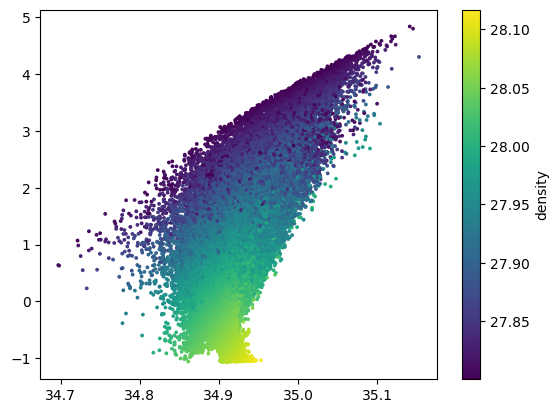

In [120]:
plt.scatter(S_WEST_cp, T_WEST_cp, c=sigma0_WEST_cp*xr.where(sigma0_WEST_cp>27.8, 1, np.nan), s=3, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('density')
plt.show()

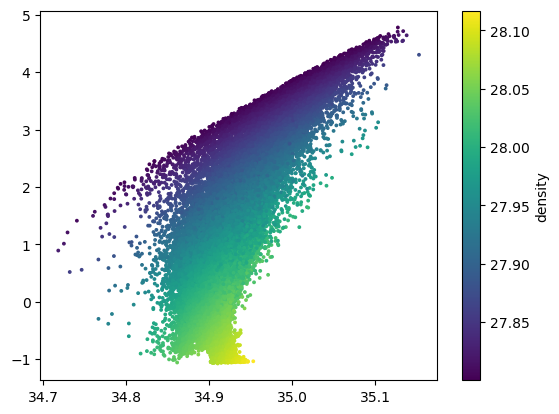

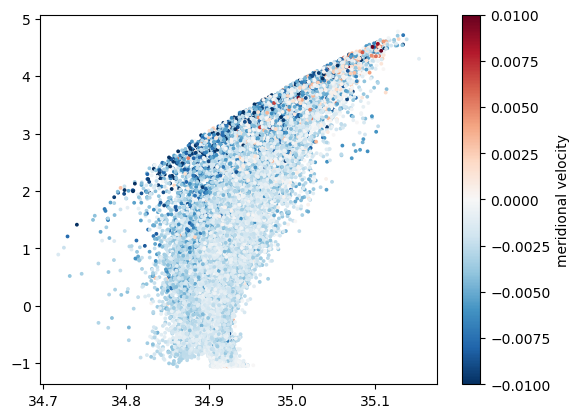

In [105]:
plt.scatter(S_WEST_dense_cp, T_WEST_dense_cp, c=sigma0_WEST_dense_cp, s=3, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('density')
plt.show()


plt.scatter(S_WEST_dense_cp, T_WEST_dense_cp, c=vvel_WEST_dense_cp*1e4, s=3,
            vmin=-.01,vmax=.01, cmap='RdBu_r')
cbar = plt.colorbar()
cbar.set_label('meridional velocity')
plt.show()


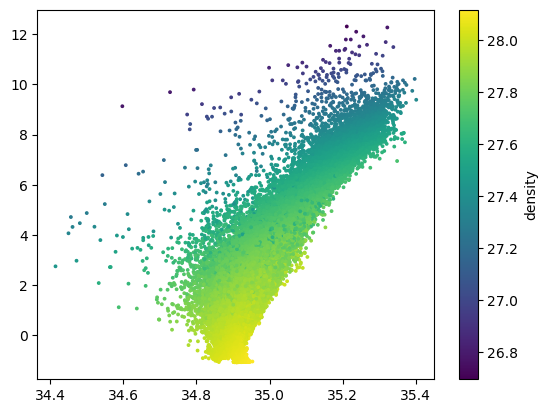

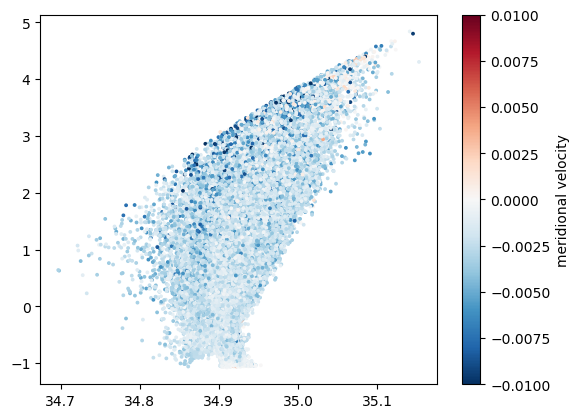

In [122]:
plt.scatter(S_WEST_cp, T_WEST_cp, c=sigma0_WEST_cp, s=3, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('density')
plt.show()

plt.scatter(S_WEST_cp, T_WEST_cp, c=1e4*vvel_WEST_cp*xr.where(sigma0_WEST_cp>27.8, 1, np.nan),
            vmin=-.01,vmax=.01, s=3, cmap='RdBu_r')
cbar = plt.colorbar()
cbar.set_label('meridional velocity')
plt.show()


In [8]:
def sigma_contour_grid(salinity, temp):
    S = salinity
    T = temp
    smin = S.min() - (0.05 * S.min())
    smax = S.max() + (0.05 * S.max())
    tmin = T.min() - (.5 * T.max()) #0.2
    tmax = T.max() + (.5 * T.max())
    tempL=np.linspace(tmin,tmax,200) #400
    salL=np.linspace(smin,smax,200) #400
    Sg,Tg = np.meshgrid(salL,tempL)

    # sigma contour lines references to surface 
    sigma_theta = gsw.eos80.pden(Sg,Tg,0) - 1000
    return Sg, Tg, sigma_theta, S, T

In [138]:
sigma_contour_WEST = sigma_contour_grid(S_WEST_cp, T_WEST_cp)
sigma_contour_WEST_dense = sigma_contour_grid(S_WEST_dense_cp, T_WEST_dense_cp)

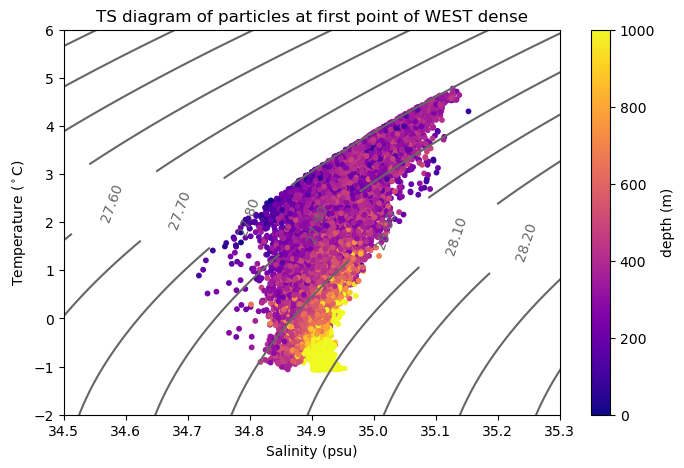

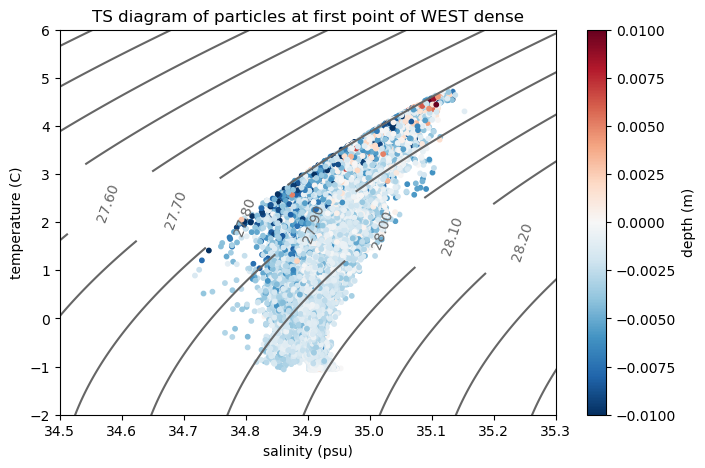

In [133]:
plt.figure(figsize=(8, 5))

# Convert datetime to int64 for color mapping
c_values = z_WEST_dense_cp

# Scatter plot
scatter = plt.scatter(S_WEST_dense_cp, T_WEST_dense_cp, 
                      c=c_values, s=10, cmap='plasma',vmin=0,vmax=1000)
cbar = plt.colorbar(scatter)
cbar.set_label('depth (m)')

manual_locations = [(34.9, 2)]
for level in np.arange(27., 28.5, 0.1):
    CS = plt.contour(sigma_contour_WEST_dense[0], sigma_contour_WEST_dense[1], sigma_contour_WEST_dense[2], [level], cmap='Dark2_r') 
    plt.clabel(CS, inline=True, fmt='%1.2f', manual=manual_locations)
plt.xlim(34.5, 35.3)
plt.ylim(-2,6)
plt.xlabel('Salinity (psu)')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('TS diagram of particles at first point of WEST dense')
plt.show()



plt.figure(figsize=(8, 5))

# Convert datetime to int64 for color mapping
c_values = vvel_WEST_dense_cp

# Scatter plot
scatter = plt.scatter(S_WEST_dense_cp, T_WEST_dense_cp, 
                      c=c_values*1e4, s=10, cmap='RdBu_r',vmin=-.01,vmax=.01)
cbar = plt.colorbar(scatter)
cbar.set_label('depth (m)')

manual_locations = [(34.9, 2)]
for level in np.arange(27., 28.5, 0.1):
    CS = plt.contour(sigma_contour_WEST_dense[0], sigma_contour_WEST_dense[1], sigma_contour_WEST_dense[2], [level], cmap='Dark2_r') 
    plt.clabel(CS, inline=True, fmt='%1.2f', manual=manual_locations)
plt.xlim(34.5, 35.3)
plt.ylim(-2,6)
plt.xlabel('salinity (psu)')
plt.ylabel('temperature (C)')
plt.title('TS diagram of particles at first point of WEST dense')
plt.show()




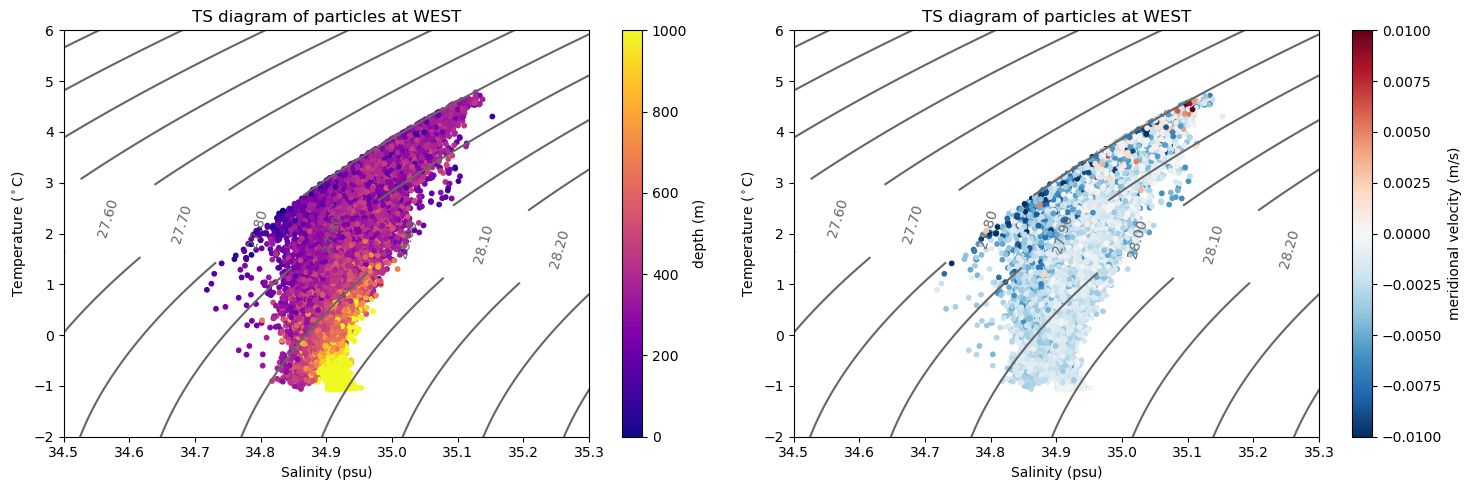

In [137]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figsize as needed

# First subplot
# Convert datetime to int64 for color mapping
c_values_dense = z_WEST_dense_cp  # Assuming z_WEST_dense_cp is defined

# Scatter plot for the first subplot
scatter1 = axs[0].scatter(S_WEST_dense_cp, T_WEST_dense_cp, 
                          c=c_values_dense, s=10, cmap='plasma', vmin=0, vmax=1000)
cbar1 = fig.colorbar(scatter1, ax=axs[0])
cbar1.set_label('depth (m)')

manual_locations = [(34.9, 2)]
for level in np.arange(27., 28.5, 0.1):
    CS = axs[0].contour(sigma_contour_WEST_dense[0], sigma_contour_WEST_dense[1], sigma_contour_WEST_dense[2], [level], cmap='Dark2_r') 
    axs[0].clabel(CS, inline=True, fmt='%1.2f', manual=manual_locations)

axs[0].set_xlim(34.5, 35.3)
axs[0].set_ylim(-2, 6)
axs[0].set_xlabel('Salinity (psu)')
axs[0].set_ylabel('Temperature ($^\circ$C)')
axs[0].set_title('TS diagram of particles at WEST')

# Second subplot
# Convert datetime to int64 for color mapping
c_values_velocity = vvel_WEST_dense_cp  # Assuming vvel_WEST_dense_cp is defined

# Scatter plot for the second subplot
scatter2 = axs[1].scatter(S_WEST_dense_cp, T_WEST_dense_cp, 
                          c=c_values_velocity * 1e4, s=10, cmap='RdBu_r', vmin=-.01, vmax=.01)
cbar2 = fig.colorbar(scatter2, ax=axs[1])
cbar2.set_label('meridional velocity (m/s)')

manual_locations = [(34.9, 2)]
for level in np.arange(27., 28.5, 0.1):
    CS = axs[1].contour(sigma_contour_WEST_dense[0], sigma_contour_WEST_dense[1], sigma_contour_WEST_dense[2], [level], cmap='Dark2_r') 
    axs[1].clabel(CS, inline=True, fmt='%1.2f', manual=manual_locations)

axs[1].set_xlim(34.5, 35.3)
axs[1].set_ylim(-2, 6)
axs[1].set_xlabel('Salinity (psu)')
axs[1].set_ylabel('Temperature ($^\circ$C)')
axs[1].set_title('TS diagram of particles at WEST')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [142]:
## svinoy:

Svinoy_TS_dense = Svinoy_TS.where(Svinoy_TS.sigma0 > 27.8, drop=False)

T_Svinoy_dense_cp = Svinoy_TS_dense.temp.mean(dim='obs').compute()
S_Svinoy_dense_cp = Svinoy_TS_dense.salt.mean(dim='obs').compute()
sigma0_Svinoy_dense_cp = Svinoy_TS_dense.sigma0.mean(dim='obs').compute()
vvel_Svinoy_dense_cp = Svinoy_TS_dense.vvel.mean(dim='obs').compute()
z_Svinoy_dense_cp = Svinoy_TS_dense.z.mean(dim='obs').compute()

sigma_contour_Svinoy_dense = sigma_contour_grid(S_Svinoy_dense_cp, T_Svinoy_dense_cp)



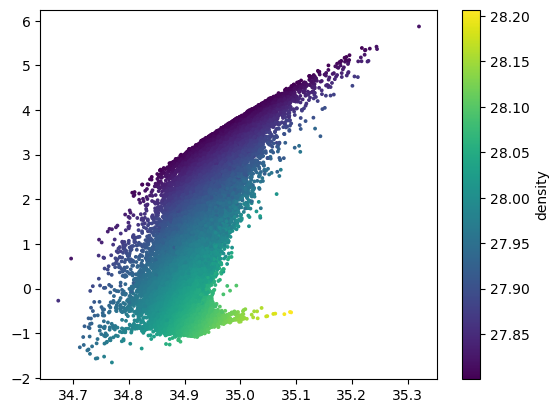

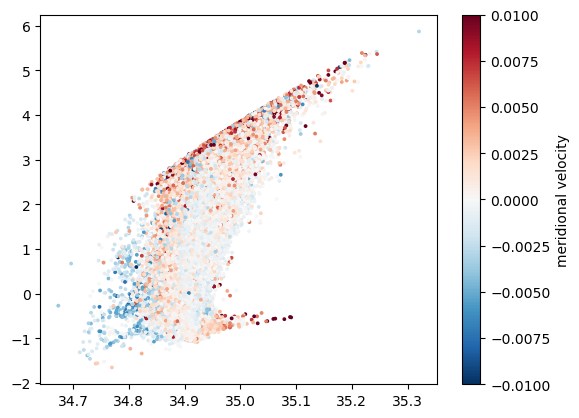

In [144]:
plt.scatter(S_Svinoy_dense_cp, T_Svinoy_dense_cp, c=sigma0_Svinoy_dense_cp, s=3, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('density')
plt.show()

plt.scatter(S_Svinoy_dense_cp, T_Svinoy_dense_cp, c=vvel_Svinoy_dense_cp*1e4, s=3,
            vmin=-.01,vmax=.01, cmap='RdBu_r')
cbar = plt.colorbar()
cbar.set_label('meridional velocity')
plt.show()


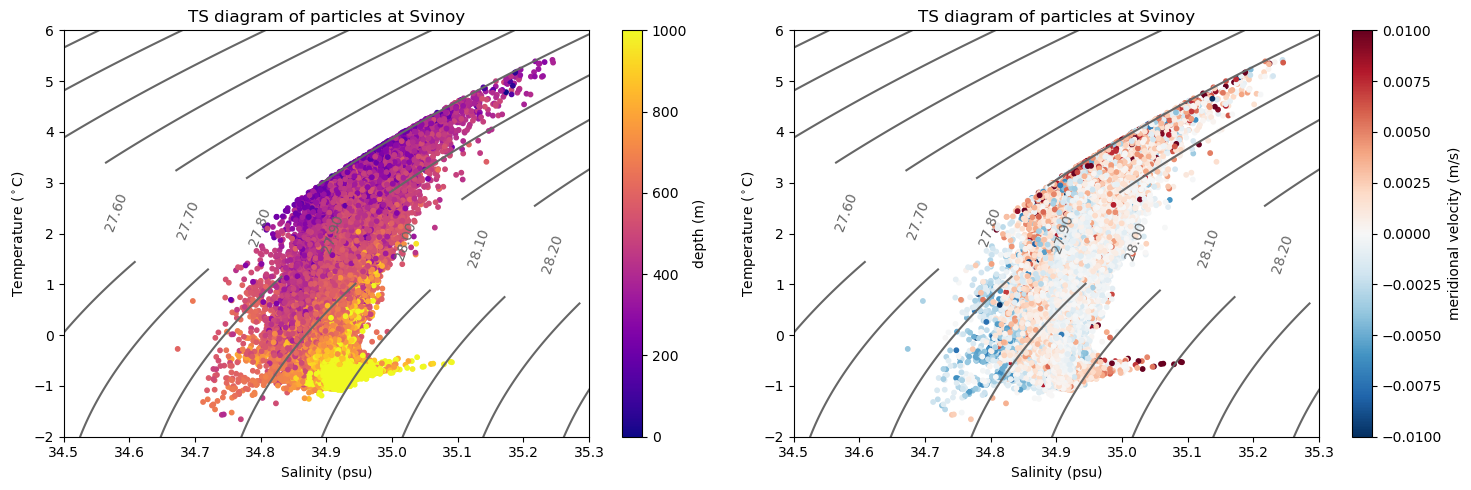

In [145]:
# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figsize as needed

# First subplot
# Convert datetime to int64 for color mapping
c_values_dense = z_Svinoy_dense_cp  # Assuming z_Svinoy_dense_cp is defined

# Scatter plot for the first subplot
scatter1 = axs[0].scatter(S_Svinoy_dense_cp, T_Svinoy_dense_cp, 
                          c=c_values_dense, s=10, cmap='plasma', vmin=0, vmax=1000)
cbar1 = fig.colorbar(scatter1, ax=axs[0])
cbar1.set_label('depth (m)')

manual_locations = [(34.9, 2)]
for level in np.arange(27., 28.5, 0.1):
    CS = axs[0].contour(sigma_contour_Svinoy_dense[0], sigma_contour_Svinoy_dense[1], sigma_contour_Svinoy_dense[2], [level], cmap='Dark2_r') 
    axs[0].clabel(CS, inline=True, fmt='%1.2f', manual=manual_locations)

axs[0].set_xlim(34.5, 35.3)
axs[0].set_ylim(-2, 6)
axs[0].set_xlabel('Salinity (psu)')
axs[0].set_ylabel('Temperature ($^\circ$C)')
axs[0].set_title('TS diagram of particles at Svinoy')

# Second subplot
# Convert datetime to int64 for color mapping
c_values_velocity = vvel_Svinoy_dense_cp  # Assuming vvel_Svinoy_dense_cp is defined

# Scatter plot for the second subplot
scatter2 = axs[1].scatter(S_Svinoy_dense_cp, T_Svinoy_dense_cp, 
                          c=c_values_velocity * 1e4, s=10, cmap='RdBu_r', vmin=-.01, vmax=.01)
cbar2 = fig.colorbar(scatter2, ax=axs[1])
cbar2.set_label('meridional velocity (m/s)')

manual_locations = [(34.9, 2)]
for level in np.arange(27., 28.5, 0.1):
    CS = axs[1].contour(sigma_contour_Svinoy_dense[0], sigma_contour_Svinoy_dense[1], sigma_contour_Svinoy_dense[2], [level], cmap='Dark2_r') 
    axs[1].clabel(CS, inline=True, fmt='%1.2f', manual=manual_locations)

axs[1].set_xlim(34.5, 35.3)
axs[1].set_ylim(-2, 6)
axs[1].set_xlabel('Salinity (psu)')
axs[1].set_ylabel('Temperature ($^\circ$C)')
axs[1].set_title('TS diagram of particles at Svinoy')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [143]:
## EAST

EAST_TS_dense = EAST_TS.where(EAST_TS.sigma0 > 27.8, drop=False)

T_EAST_dense_cp = EAST_TS_dense.temp.mean(dim='obs').compute()
S_EAST_dense_cp = EAST_TS_dense.salt.mean(dim='obs').compute()
sigma0_EAST_dense_cp = EAST_TS_dense.sigma0.mean(dim='obs').compute()
vvel_EAST_dense_cp = EAST_TS_dense.vvel.mean(dim='obs').compute()
z_EAST_dense_cp = EAST_TS_dense.z.mean(dim='obs').compute()

sigma_contour_EAST_dense = sigma_contour_grid(S_EAST_dense_cp, T_EAST_dense_cp)


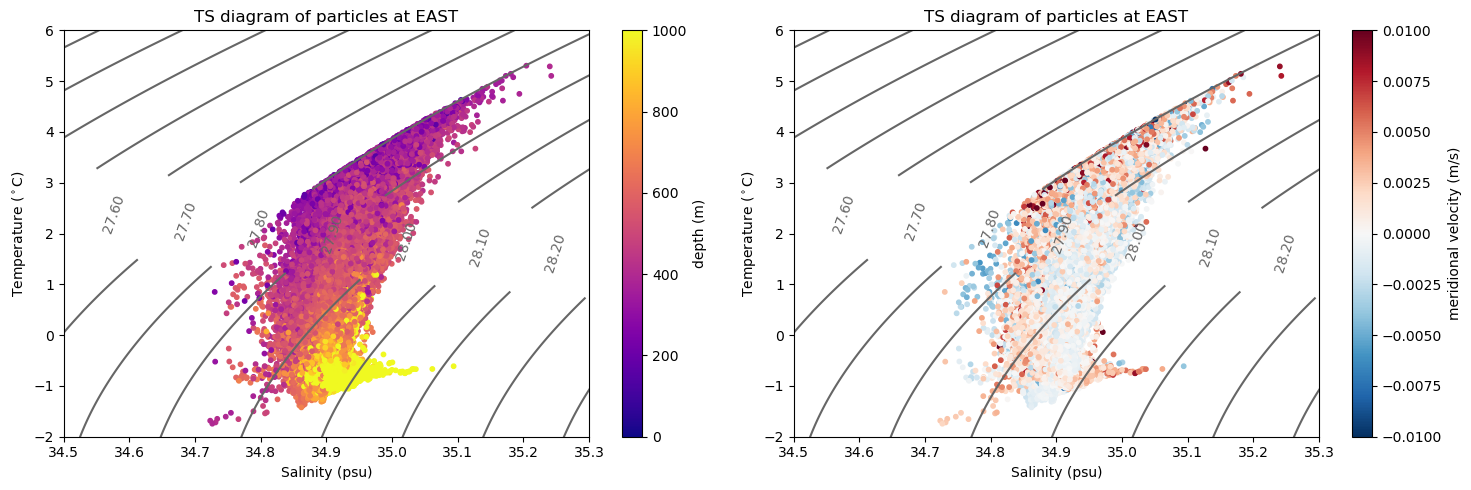

In [146]:
# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figsize as needed

# First subplot
# Convert datetime to int64 for color mapping
c_values_dense = z_EAST_dense_cp  # Assuming z_EAST_dense_cp is defined

# Scatter plot for the first subplot
scatter1 = axs[0].scatter(S_EAST_dense_cp, T_EAST_dense_cp, 
                          c=c_values_dense, s=10, cmap='plasma', vmin=0, vmax=1000)
cbar1 = fig.colorbar(scatter1, ax=axs[0])
cbar1.set_label('depth (m)')

manual_locations = [(34.9, 2)]
for level in np.arange(27., 28.5, 0.1):
    CS = axs[0].contour(sigma_contour_EAST_dense[0], sigma_contour_EAST_dense[1], sigma_contour_EAST_dense[2], [level], cmap='Dark2_r') 
    axs[0].clabel(CS, inline=True, fmt='%1.2f', manual=manual_locations)

axs[0].set_xlim(34.5, 35.3)
axs[0].set_ylim(-2, 6)
axs[0].set_xlabel('Salinity (psu)')
axs[0].set_ylabel('Temperature ($^\circ$C)')
axs[0].set_title('TS diagram of particles at EAST')

# Second subplot
# Convert datetime to int64 for color mapping
c_values_velocity = vvel_EAST_dense_cp  # Assuming vvel_EAST_dense_cp is defined

# Scatter plot for the second subplot
scatter2 = axs[1].scatter(S_EAST_dense_cp, T_EAST_dense_cp, 
                          c=c_values_velocity * 1e4, s=10, cmap='RdBu_r', vmin=-.01, vmax=.01)
cbar2 = fig.colorbar(scatter2, ax=axs[1])
cbar2.set_label('meridional velocity (m/s)')

manual_locations = [(34.9, 2)]
for level in np.arange(27., 28.5, 0.1):
    CS = axs[1].contour(sigma_contour_EAST_dense[0], sigma_contour_EAST_dense[1], sigma_contour_EAST_dense[2], [level], cmap='Dark2_r') 
    axs[1].clabel(CS, inline=True, fmt='%1.2f', manual=manual_locations)

axs[1].set_xlim(34.5, 35.3)
axs[1].set_ylim(-2, 6)
axs[1].set_xlabel('Salinity (psu)')
axs[1].set_ylabel('Temperature ($^\circ$C)')
axs[1].set_title('TS diagram of particles at EAST')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [9]:
## Voring plateau 

VP_TS_dense = VP_TS.where(VP_TS.sigma0 > 27.8, drop=False)

T_VP_dense_cp = VP_TS_dense.temp.mean(dim='obs').compute()
S_VP_dense_cp = VP_TS_dense.salt.mean(dim='obs').compute()
sigma0_VP_dense_cp = VP_TS_dense.sigma0.mean(dim='obs').compute()
vvel_VP_dense_cp = VP_TS_dense.vvel.mean(dim='obs').compute()
z_VP_dense_cp = VP_TS_dense.z.mean(dim='obs').compute()

sigma_contour_VP_dense = sigma_contour_grid(S_VP_dense_cp, T_VP_dense_cp)


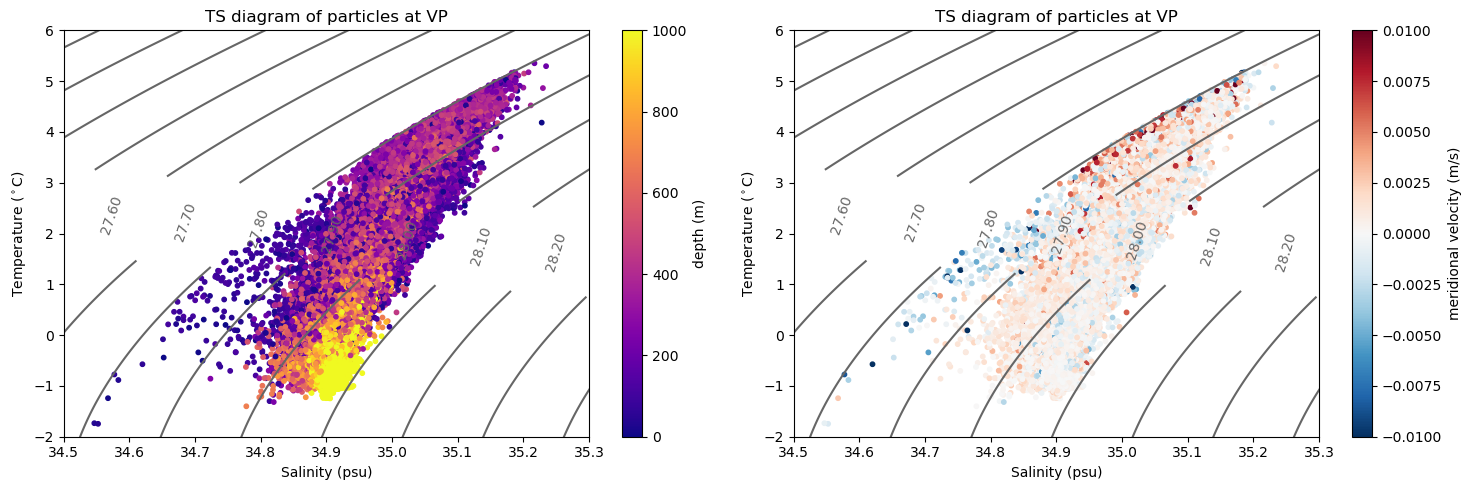

In [12]:
# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figsize as needed

# First subplot
# Convert datetime to int64 for color mapping
c_values_dense = z_VP_dense_cp  # Assuming z_VP_dense_cp is defined

# Scatter plot for the first subplot
scatter1 = axs[0].scatter(S_VP_dense_cp, T_VP_dense_cp, 
                          c=c_values_dense, s=10, cmap='plasma', vmin=0, vmax=1000)
cbar1 = fig.colorbar(scatter1, ax=axs[0])
cbar1.set_label('depth (m)')

manual_locations = [(34.9, 2)]
for level in np.arange(27., 28.5, 0.1):
    CS = axs[0].contour(sigma_contour_VP_dense[0], sigma_contour_VP_dense[1], sigma_contour_VP_dense[2], [level], cmap='Dark2_r') 
    axs[0].clabel(CS, inline=True, fmt='%1.2f', manual=manual_locations)

axs[0].set_xlim(34.5, 35.3)
axs[0].set_ylim(-2, 6)
axs[0].set_xlabel('Salinity (psu)')
axs[0].set_ylabel('Temperature ($^\circ$C)')
axs[0].set_title('TS diagram of particles at VP')

# Second subplot
# Convert datetime to int64 for color mapping
c_values_velocity = vvel_VP_dense_cp  # Assuming vvel_VP_dense_cp is defined

# Scatter plot for the second subplot
scatter2 = axs[1].scatter(S_VP_dense_cp, T_VP_dense_cp, 
                          c=c_values_velocity * 1e4, s=10, cmap='RdBu_r', vmin=-.01, vmax=.01)
cbar2 = fig.colorbar(scatter2, ax=axs[1])
cbar2.set_label('meridional velocity (m/s)')

manual_locations = [(34.9, 2)]
for level in np.arange(27., 28.5, 0.1):
    CS = axs[1].contour(sigma_contour_VP_dense[0], sigma_contour_VP_dense[1], sigma_contour_VP_dense[2], [level], cmap='Dark2_r') 
    axs[1].clabel(CS, inline=True, fmt='%1.2f', manual=manual_locations)

axs[1].set_xlim(34.5, 35.3)
axs[1].set_ylim(-2, 6)
axs[1].set_xlabel('Salinity (psu)')
axs[1].set_ylabel('Temperature ($^\circ$C)')
axs[1].set_title('TS diagram of particles at VP')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [6]:
# subsample = ds.isel(trajectory=slice(0, 100))

In [7]:
# ds_traj = subsample

# # Define the region of interest (the section)
# # Adjust the coordinates as necessary for your specific case
# WEST_subsample = (ds_traj.lon > -8) & (ds_traj.lat > 62.5) & (ds_traj.lon < -5) & (ds_traj.lat < 64.5)


In [8]:
ds

<xarray.Dataset>
Dimensions:     (trajectory: 497743, obs: 20075)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 ... 20069 20070 20071 20072 20073 20074
  * trajectory  (trajectory) int64 1 8 9 14 ... 3518721 3518723 3518726 3518727
Data variables:
    age         (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    lat         (trajectory, obs) float64 dask.array<chunksize=(782, 15330), meta=np.ndarray>
    lon         (trajectory, obs) float64 dask.array<chunksize=(782, 15330), meta=np.ndarray>
    salt        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    temp        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(782, 15330), meta=np.ndarray>
    uvel        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    vvel        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    z           (trajectory, obs) float64 dask.array<chunksize=(782, 15330), meta=np.ndarray>
    sigma0      (trajectory, obs) float64 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    start_time  (trajectory) datetime64[ns] dask.array<chunksize=(782,), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

In [9]:
inpath = "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/data/"
level1_files = sorted(glob(inpath + "level1/parcels_releases_seed-2345_*.zarr"))
print(f"{len(level1_files)} found")
global trj_idx
trj_idx = 0

def preprocess(ds):
    """
    The trajecetories in each dataset start with 0, to make them compatible
    we add the last trajectory index to each trajectory.
    """
    global trj_idx
    trj_number = max(ds["trajectory"])
    ds["trajectory"] = ds["trajectory"] + trj_idx
    start_time = pd.to_datetime(ds["time"].isel(trajectory=0,obs=0).values)
    freq = "-12H"
    time = pd.date_range(start=start_time, periods=len(ds["obs"]), freq=freq)
    ds["obs"] = time
    del ds['time']
    ds = ds.rename({"obs": "time"})
    trj_idx = trj_idx + trj_number
    return ds


ds = xr.open_mfdataset(
    level1_files[::-1][:3],
    engine="zarr",
    preprocess=preprocess,
    combine="nested",
)

#ds.to_zarr()


1273 found


In [ ]:
ds.to_zarr()

In [17]:
ds.age

<xarray.DataArray 'age' (trajectory: 1173, time: 40160)>
dask.array<where, shape=(1173, 40160), dtype=float32, chunksize=(1173, 40160), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1992-11-27 ... 2020-05-31T00:00:01
  * trajectory  (trajectory) int64 1 8 9 14 17 21 ... 3990 3991 3993 3996 3997
Attributes:
    long_name:      
    standard_name:  age
    units:          unknown

In [134]:
ds

<xarray.Dataset>
Dimensions:     (time: 40150, trajectory: 782)
Coordinates:
  * time        (time) datetime64[ns] 1992-12-02 ... 2020-05-31T00:00:01
  * trajectory  (trajectory) int64 1 8 9 14 17 21 ... 2991 2992 2994 2997 2998
Data variables:
    age         (trajectory, time) float32 dask.array<chunksize=(782, 40150), meta=np.ndarray>
    lat         (trajectory, time) float64 dask.array<chunksize=(782, 40150), meta=np.ndarray>
    lon         (trajectory, time) float64 dask.array<chunksize=(782, 40150), meta=np.ndarray>
    salt        (trajectory, time) float32 dask.array<chunksize=(782, 40150), meta=np.ndarray>
    temp        (trajectory, time) float32 dask.array<chunksize=(782, 40150), meta=np.ndarray>
    uvel        (trajectory, time) float32 dask.array<chunksize=(782, 40150), meta=np.ndarray>
    vvel        (trajectory, time) float32 dask.array<chunksize=(782, 40150), meta=np.ndarray>
    z           (trajectory, time) float64 dask.array<chunksize=(782, 40150), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

In [135]:
ds_traj = ds
WEST_subsample = (ds_traj.lon > -8) & (ds_traj.lat > 62.5) & (ds_traj.lon < -5) & (ds_traj.lat < 64.5)

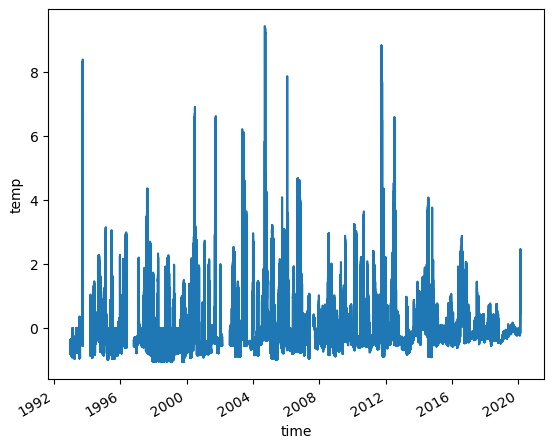

In [137]:
ds_traj[['lat','lon','temp']].where(WEST_subsample, np.nan)['temp'].mean('trajectory').plot()

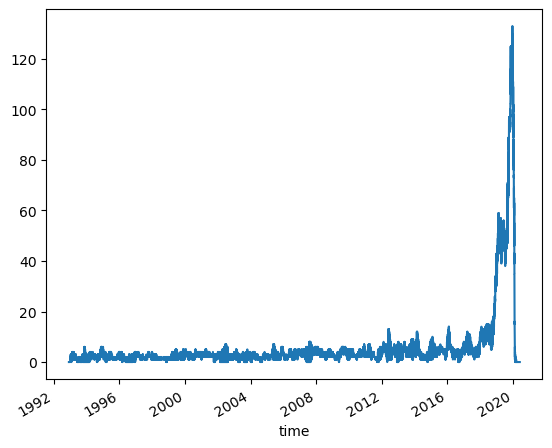

In [139]:
WEST_subsample.sum('trajectory').plot()

In [43]:
ds_traj["before_section"] = (~WEST_subsample).astype(int)

In [44]:
ds_traj["will_cross_section"] = ds_traj.before_section.astype(int).diff("obs", label="lower") == -1  # will be True for obs step _before_ particle crosses
ds_traj["release_lon"] = ds_traj.lon.isel(obs=0, drop=True)
ds_traj["release_lat"] = ds_traj.lat.isel(obs=0, drop=True)
ds_traj["release_temp"] = ds_traj.temp.isel(obs=0, drop=True)
ds_traj["release_salt"] = ds_traj.salt.isel(obs=0, drop=True)


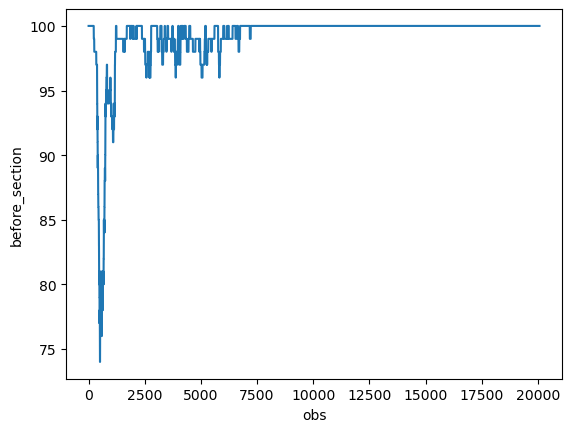

In [45]:
ds_traj.before_section.sum(dim='trajectory').plot();

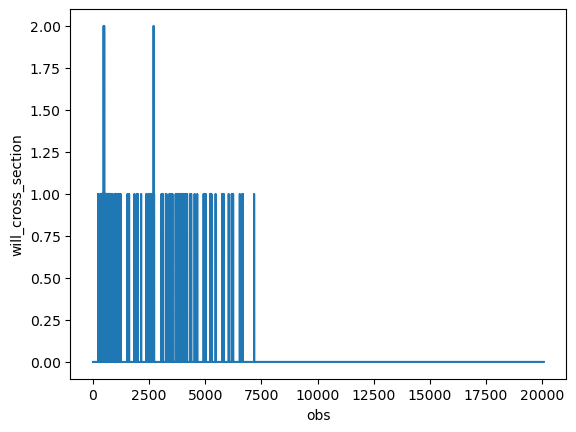

In [46]:
ds_traj.will_cross_section.sum(dim='trajectory').plot();

In [48]:
ds_traj

<xarray.Dataset>
Dimensions:             (obs: 20075, trajectory: 100)
Coordinates:
  * obs                 (obs) int32 0 1 2 3 4 ... 20070 20071 20072 20073 20074
  * trajectory          (trajectory) int64 1 8 9 14 17 ... 237 238 240 241 246
Data variables: (12/16)
    age                 (trajectory, obs) float32 dask.array<chunksize=(100, 20075), meta=np.ndarray>
    lat                 (trajectory, obs) float64 dask.array<chunksize=(100, 15330), meta=np.ndarray>
    lon                 (trajectory, obs) float64 dask.array<chunksize=(100, 15330), meta=np.ndarray>
    salt                (trajectory, obs) float32 dask.array<chunksize=(100, 20075), meta=np.ndarray>
    temp                (trajectory, obs) float32 dask.array<chunksize=(100, 20075), meta=np.ndarray>
    time                (trajectory, obs) datetime64[ns] dask.array<chunksize=(100, 15330), meta=np.ndarray>
    ...                  ...
    before_section      (trajectory, obs) int64 dask.array<chunksize=(100, 15330), meta=np.ndarray>
    will_cross_section  (trajectory, obs) float64 dask.array<chunksize=(100, 15329), meta=np.ndarray>
    release_lon         (trajectory) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    release_lat         (trajectory) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    release_temp        (trajectory) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    release_salt        (trajectory) float32 dask.array<chunksize=(100,), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

In [47]:
df_traj = ds_traj.to_dataframe().reset_index()


In [21]:
# find number of particles crossing the section per day
crossings_per_day = df_traj.set_index("time")["will_cross_section"].resample("1D").sum()

crossings_per_day_before_sec = df_traj.set_index("time")["before_section"].resample("1D").sum()



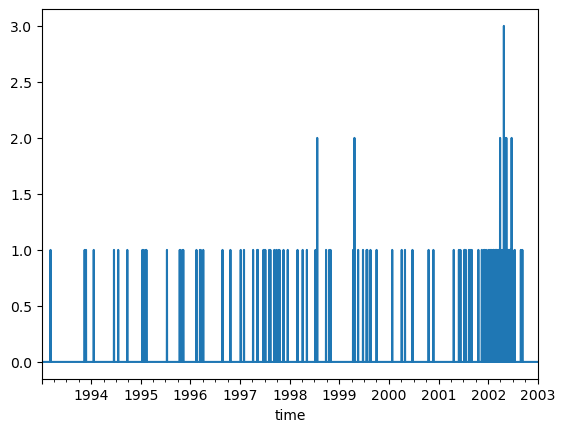

In [22]:
crossings_per_day.plot();

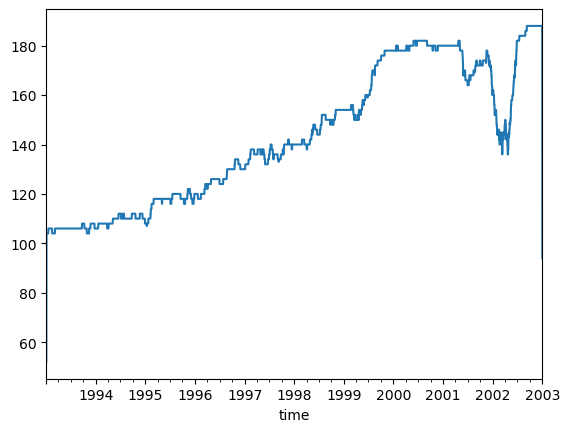

In [23]:
crossings_per_day_before_sec.plot();

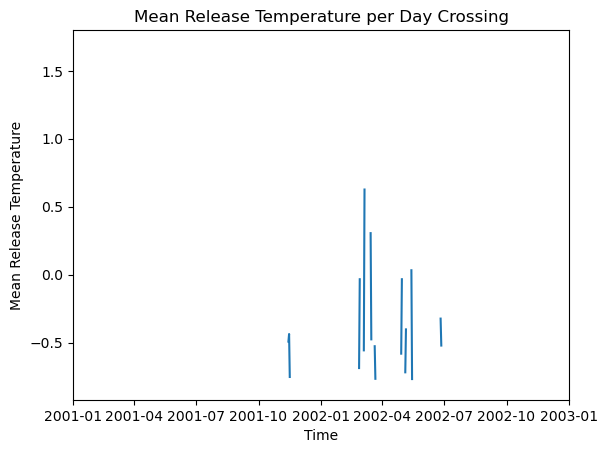

In [25]:
mean_release_temp_per_day_crossing = df_traj[df_traj.will_cross_section == 1].dropna().set_index("time")["release_temp"].resample("1D").mean()

plt.plot(mean_release_temp_per_day_crossing)
plt.xlim(pd.to_datetime('2001-01-01'), pd.to_datetime('2003-01-01'))  # Set the x-axis limits
plt.xlabel('Time')
plt.ylabel('Mean Release Temperature')
plt.title('Mean Release Temperature per Day Crossing')
plt.show()

<Axes: xlabel='time'>

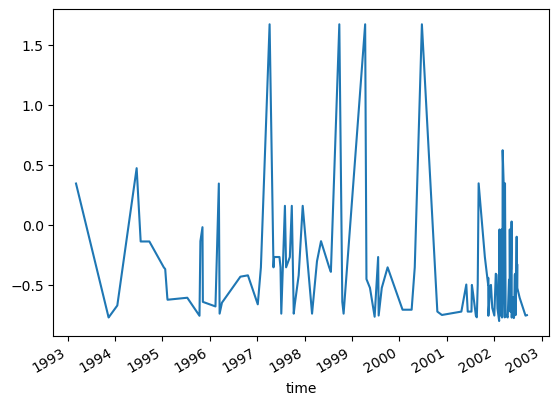

In [28]:
mean_release_temp_per_day_crossing.dropna().plot()

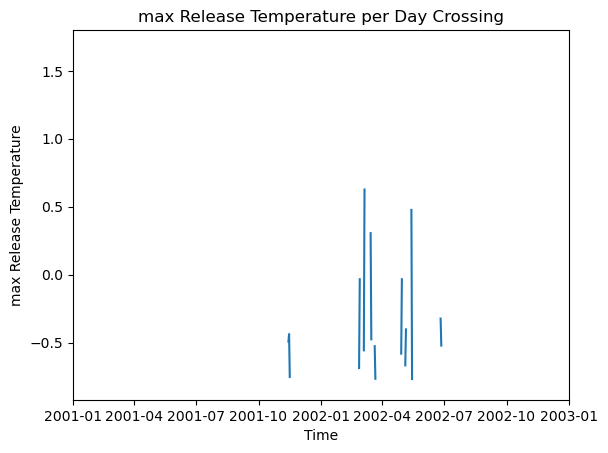

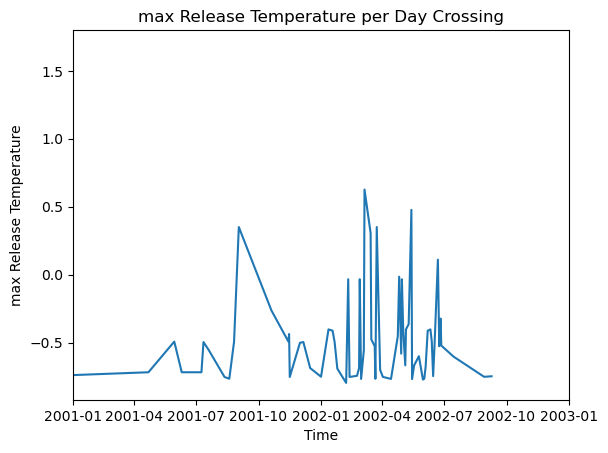

In [30]:
max_release_temp_per_day_crossing = df_traj[df_traj.will_cross_section == 1].dropna().set_index("time")["release_temp"].resample("1D").max()

plt.plot(max_release_temp_per_day_crossing)
plt.xlim(pd.to_datetime('2001-01-01'), pd.to_datetime('2003-01-01'))  # Set the x-axis limits
plt.xlabel('Time')
plt.ylabel('max Release Temperature')
plt.title('max Release Temperature per Day Crossing')
plt.show()

plt.plot(max_release_temp_per_day_crossing.dropna())
plt.xlim(pd.to_datetime('2001-01-01'), pd.to_datetime('2003-01-01'))  # Set the x-axis limits
plt.xlabel('Time')
plt.ylabel('max Release Temperature')
plt.title('max Release Temperature per Day Crossing')
plt.show()

In [31]:
max_release_temp_per_day_crossing.dropna()

time
1993-03-07    0.348770
1993-11-13   -0.767110
1993-11-23   -0.752257
1994-01-19   -0.667359
1994-06-17    0.476797
                ...   
2002-06-26   -0.323383
2002-06-27   -0.521673
2002-07-15   -0.602867
2002-08-29   -0.751679
2002-09-09   -0.747740
Name: release_temp, Length: 126, dtype: float32

In [1]:
import xarray as xr
# import matplotlib.pyplot as plt
import datetime
from glob import glob
import dask, dask.distributed
import dask_jobqueue
import copy
import matplotlib.pyplot as plt
import datetime
import numpy as np
# import parcels
import pandas as pd
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
cluster = dask_jobqueue.SLURMCluster(

    # Dask worker size
    cores=4, memory='50GB',
    processes=1, # Dask workers per job
    
    # SLURM job script things
    queue='base', walltime='10:00:00',
    
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',  # for spilling tmp data to disk
    log_directory='slurm/' 
)

client = dask.distributed.Client(cluster)

cluster.adapt(minimum=1, maximum=15)
print(client)


<Client: 'tcp://172.18.4.23:36387' processes=0 threads=0, memory=0 B>


In [ ]:
inpath = "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/data/"
level1_files = sorted(glob(inpath + "level1/parcels_releases_seed-2345_*.zarr"))
print(f"{len(level1_files)} found")
global trj_idx
trj_idx = 0

entire_times = pd.date_range(start='2020-05-31', end='1993-01-01', freq='-12H')

def preprocess(ds):
    """
    The trajecetories in each dataset start with 0, to make them compatible
    we add the last trajectory index to each trajectory.
    """
    global trj_idx
    trj_number = max(ds["trajectory"])
    ds["trajectory"] = ds["trajectory"] + trj_idx
    start_time = pd.to_datetime(ds["time"].isel(trajectory=0,obs=0).values)
    freq = "-12H"
    time = pd.date_range(start=start_time, periods=len(ds["obs"]), freq=freq)
    ds["obs"] = time
    del ds['time']
    ds = ds.rename({"obs": "time"})
    ds = ds.reindex(time=entire_times)
    trj_idx = trj_idx + trj_number
    return ds

print("Let's get cracking")

# Split level1_files into several sublists for parallel processing
sublists = [level1_files[i:i + 100] for i in range(0, len(level1_files), 100)]

for f, filelist in enumerate(tqdm.tqdm(sublists)): 
    dss = []
    for file in tqdm.tqdm(filelist):
        
        ds = xr.open_dataset(file, engine='zarr')
        ds = preprocess(ds)
        dss.append(ds)

    ds_merged = xr.concat(dss, dim='trajectory')
    ds_merged.to_zarr(f"data/level2/with_time_parcels_releases_seed-2345_{f:03d}.zarr", mode="w", consolidated=True)


In [24]:

# inpath = "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/data/"
# level1_files = sorted(glob(inpath + "level1/parcels_releases_seed-2345_*.zarr"))
# print(f"{len(level1_files)} found")
# global trj_idx
# trj_idx = 0

# entire_times = pd.date_range(start='2020-05-31', end='1993-01-01', freq='-12H')

# def preprocess(ds):
#     """
#     The trajecetories in each dataset start with 0, to make them compatible
#     we add the last trajectory index to each trajectory.
#     """
#     global trj_idx
#     trj_number = max(ds["trajectory"])
#     ds["trajectory"] = ds["trajectory"] + trj_idx
#     start_time = pd.to_datetime(ds["time"].isel(trajectory=0,obs=0).values)
#     freq = "-12H"
#     time = pd.date_range(start=start_time, periods=len(ds["obs"]), freq=freq)
#     ds["obs"] = time
#     del ds['time']
#     ds = ds.rename({"obs": "time"})
#     ds = ds.reindex(time=entire_times)
#     trj_idx = trj_idx + trj_number
#     return ds

# print("Let's get cracking")

# # Split level1_files into several sublists for parallel processing
# sublists = [level1_files[i:i + 100] for i in range(0, len(level1_files), 100)]

# for f, filelist in tqdm.tqdm(enumerate(sublists)):
#     dss = []
#     for file in tqdm.tqdm(filelist):
        
#         ds = xr.open_dataset(file, engine='zarr')
#         ds = preprocess(ds)
#         dss.append(ds)

#         ds_merged = xr.concat(dss, dim='trajectory')
#         ds_merged.to_zarr(f"data/level2/with_time_parcels_releases_seed-2345_{f:03d}.zarr", mode="w", consolidated=True)


1273 found
Let's get cracking


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


In [42]:
## trial


inpath = "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/data/"
level1_files = sorted(glob(inpath + "level1/parcels_releases_seed-2345_*.zarr"))
print(f"{len(level1_files)} found")
global trj_idx
trj_idx = 0

entire_times = pd.date_range(start='2020-05-31', end='1993-01-01', freq='-12H')

def preprocess(ds):
    """
    The trajecetories in each dataset start with 0, to make them compatible
    we add the last trajectory index to each trajectory.
    """
    global trj_idx
    trj_number = max(ds["trajectory"])
    ds["trajectory"] = ds["trajectory"] + trj_idx
    start_time = pd.to_datetime(ds["time"].isel(trajectory=0,obs=0).values)
    freq = "-12H"
    time = pd.date_range(start=start_time, periods=len(ds["obs"]), freq=freq)
    ds["obs"] = time
    del ds['time']
    ds = ds.rename({"obs": "time"})
    ds = ds.reindex(time=entire_times)
    trj_idx = trj_idx + trj_number
    return ds

print("Let's get cracking")

# Initialize a dictionary to hold datasets for each year
yearly_datasets = {year: [] for year in range(2003, 2021)}

# Process each file and append to the corresponding year
for file in tqdm.tqdm(level1_files[:20]):
    ds = xr.open_dataset(file, engine='zarr')
    ds = preprocess(ds)
    
    # Extract the year from the dataset's time coordinate
    year = ds['time'].dt.year.values[0]  # Assuming 'time' is the coordinate
    
    # Append the dataset to the corresponding year's list
    if year in yearly_datasets:
        yearly_datasets[year].append(ds)

# Now save each year's datasets
for year, datasets in yearly_datasets.items():
    if datasets:  # Check if there are datasets for the year
        ds_merged = xr.concat(datasets, dim='trajectory')
        output_filename = f"with_time_parcels_releases_seed-2345_{year}.zarr"  # Change the file format as needed
        ds_merged.to_zarr('data/level2/'+output_filename, mode='w', consolidated=True)  # Save as Zarr
        print(f"Saved {output_filename} for year {year}")

#ds_merged.to_zarr("data/level2/with_time_parcels_releases_seed-2345_.zarr", mode="w", consolidated=True)


1273 found
Let's get cracking


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Saved with_time_parcels_releases_seed-2345_2020.zarr for year 2020


In [41]:
#ds['time'].dt.year.values[0]

ds_merged

<xarray.Dataset>
Dimensions:     (time: 20025, trajectory: 7820)
Coordinates:
  * time        (time) datetime64[ns] 2020-05-31 ... 1993-01-01
  * trajectory  (trajectory) int64 1 8 9 14 17 ... 29973 29974 29976 29979 29980
Data variables:
    age         (trajectory, time) float32 nan nan nan nan ... nan nan nan nan
    lat         (trajectory, time) float64 nan nan nan nan ... nan nan nan nan
    lon         (trajectory, time) float64 nan nan nan nan ... nan nan nan nan
    salt        (trajectory, time) float32 nan nan nan nan ... nan nan nan nan
    temp        (trajectory, time) float32 nan nan nan nan ... nan nan nan nan
    uvel        (trajectory, time) float32 nan nan nan nan ... nan nan nan nan
    vvel        (trajectory, time) float32 nan nan nan nan ... nan nan nan nan
    z           (trajectory, time) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

In [39]:
ds_merged

<xarray.Dataset>
Dimensions:     (time: 20025, trajectory: 3910)
Coordinates:
  * time        (time) datetime64[ns] 2020-05-31 ... 1993-01-01
  * trajectory  (trajectory) int64 1 8 9 14 17 ... 14983 14984 14986 14989 14990
Data variables:
    age         (trajectory, time) float32 nan nan nan nan ... nan nan nan nan
    lat         (trajectory, time) float64 nan nan nan nan ... nan nan nan nan
    lon         (trajectory, time) float64 nan nan nan nan ... nan nan nan nan
    salt        (trajectory, time) float32 nan nan nan nan ... nan nan nan nan
    temp        (trajectory, time) float32 nan nan nan nan ... nan nan nan nan
    uvel        (trajectory, time) float32 nan nan nan nan ... nan nan nan nan
    vvel        (trajectory, time) float32 nan nan nan nan ... nan nan nan nan
    z           (trajectory, time) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

In [31]:
len(level1_files)

1273

In [22]:
trj_idx = 0
trj_number = max(ds["trajectory"])
ds["trajectory"] = ds["trajectory"] + trj_idx
start_time = pd.to_datetime(ds["time"].isel(trajectory=0,obs=0).values)
freq = "12H"
time = pd.date_range(start=start_time, periods=len(ds["obs"]), freq=freq)
time

ValueError: Dimensions {'obs', 'trajectory'} do not exist. Expected one or more of ('time',)

In [18]:
ds_merged.time

<xarray.DataArray 'time' (time: 20025)>
array(['2020-05-31T00:00:00.000000000', '2020-05-30T12:00:00.000000000',
       '2020-05-30T00:00:00.000000000', ..., '1993-01-02T00:00:00.000000000',
       '1993-01-01T12:00:00.000000000', '1993-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-05-31 2020-05-30T12:00:00 ... 1993-01-01

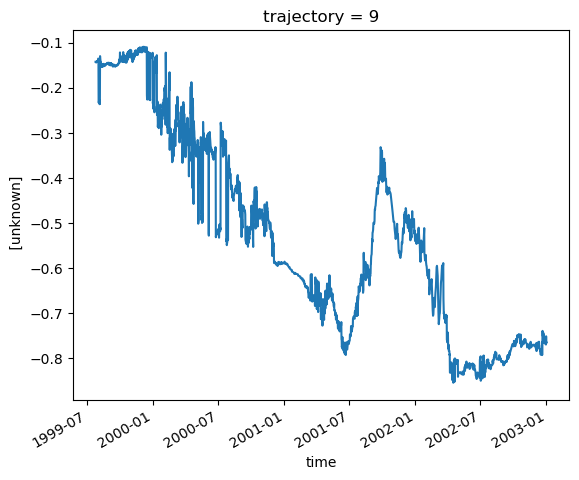

In [37]:
ds_merged.temp.isel(trajectory=2).plot()

In [37]:
# ds = xr.open_mfdataset(
#     level1_files[::-1],
#     engine="zarr",
#     preprocess=preprocess,
#     combine="nested",
#     decode_times=False,
#     parallel=True,
# )

In [ ]:
client.close()

In [73]:
ds = xr.open_mfdataset(
    'data/level2/with_time_parcels_releases_seed-2345_0*.zarr',
    engine="zarr",
    combine="nested",
    concat_dim="trajectory",
)


# Saving the rechunked output
for var in ds.data_vars:
    del ds[var].encoding["chunks"]
    del ds[var].encoding['preferred_chunks']

ds.chunk({'trajectory':391, 'time': 20025}).to_zarr("data/level2/with_time_parcels_releases_seed-2345.zarr", mode="w", consolidated=True)

In [71]:
ds[var].encoding

{'preferred_chunks': {'trajectory': 391, 'time': 7665},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float32')}

In [55]:
ds

<xarray.Dataset>
Dimensions:     (trajectory: 497743, time: 20025)
Coordinates:
  * time        (time) datetime64[ns] 2020-05-31 ... 1993-01-01
  * trajectory  (trajectory) int64 1 8 9 14 ... 3518721 3518723 3518726 3518727
Data variables:
    age         (trajectory, time) float32 dask.array<chunksize=(391, 7665), meta=np.ndarray>
    lat         (trajectory, time) float64 dask.array<chunksize=(391, 7665), meta=np.ndarray>
    lon         (trajectory, time) float64 dask.array<chunksize=(391, 7665), meta=np.ndarray>
    salt        (trajectory, time) float32 dask.array<chunksize=(391, 7665), meta=np.ndarray>
    temp        (trajectory, time) float32 dask.array<chunksize=(391, 7665), meta=np.ndarray>
    uvel        (trajectory, time) float32 dask.array<chunksize=(391, 7665), meta=np.ndarray>
    vvel        (trajectory, time) float32 dask.array<chunksize=(391, 7665), meta=np.ndarray>
    z           (trajectory, time) float64 dask.array<chunksize=(391, 7665), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

In [75]:
ds_in = xr.open_zarr('data/level2/with_time_parcels_releases_seed-2345.zarr')

In [76]:
ds_in

<xarray.Dataset>
Dimensions:     (trajectory: 497743, time: 20025)
Coordinates:
  * time        (time) datetime64[ns] 2020-05-31 ... 1993-01-01
  * trajectory  (trajectory) int64 1 8 9 14 ... 3518721 3518723 3518726 3518727
Data variables:
    age         (trajectory, time) float32 dask.array<chunksize=(391, 20025), meta=np.ndarray>
    lat         (trajectory, time) float64 dask.array<chunksize=(391, 20025), meta=np.ndarray>
    lon         (trajectory, time) float64 dask.array<chunksize=(391, 20025), meta=np.ndarray>
    salt        (trajectory, time) float32 dask.array<chunksize=(391, 20025), meta=np.ndarray>
    temp        (trajectory, time) float32 dask.array<chunksize=(391, 20025), meta=np.ndarray>
    uvel        (trajectory, time) float32 dask.array<chunksize=(391, 20025), meta=np.ndarray>
    vvel        (trajectory, time) float32 dask.array<chunksize=(391, 20025), meta=np.ndarray>
    z           (trajectory, time) float64 dask.array<chunksize=(391, 20025), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

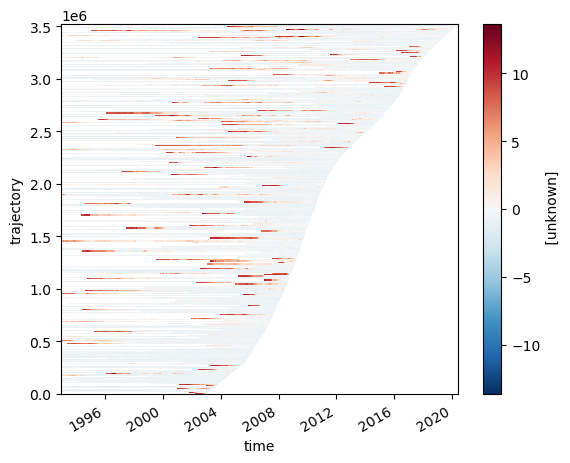

In [ ]:
ds_in.isel(trajectory=slice(1,-1,1000)).temp.plot()

In [83]:
ds = ds_in
WEST = (ds.lon > -8) & (ds.lat > 62.5) & (ds.lon < -5) & (ds.lat < 64.5)
EAST = (ds.lon > 0) & (ds.lat < 64.5) & (ds.lon < 2.5) & (ds.lat > 62.5) 

In [96]:
ds_density = xr.apply_ufunc(gsw.eos80.pden,ds.salt,ds.temp,0,dask='parallelized',output_dtypes=[np.float64]) - 1000

# assigning density to the ds!
ds_add_dens = ds.assign(sigma0=ds_density)
ds = ds_add_dens

In [99]:
ds_sigma_thresh = ds.where(ds.sigma0 > 28, drop=False)

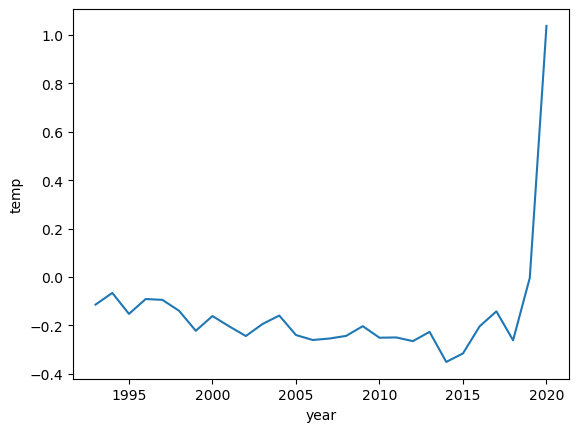

In [84]:
ds.where(WEST).temp.mean('trajectory').groupby('time.year').mean(dim='time').plot() # in 2008, what's the mean temp of all the trajectories going 

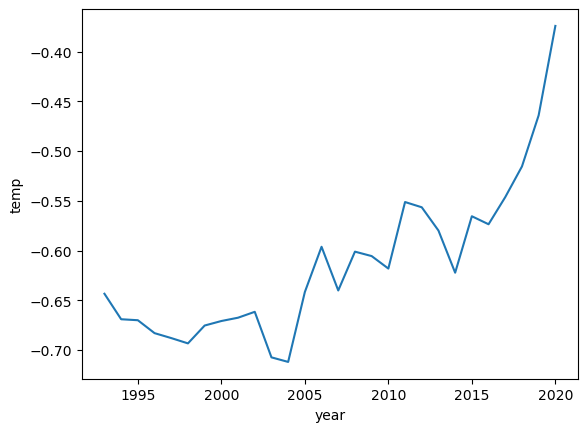

In [100]:

ds_sigma_thresh.where(EAST).temp.mean('trajectory').groupby('time.year').mean(dim='time').plot() # in 2008, what's the mean temp of all the trajectories going 

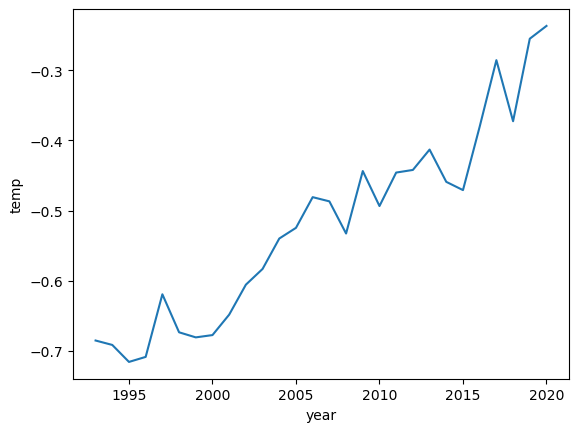

In [101]:

ds_sigma_thresh.where(WEST).temp.mean('trajectory').groupby('time.year').mean(dim='time').plot()

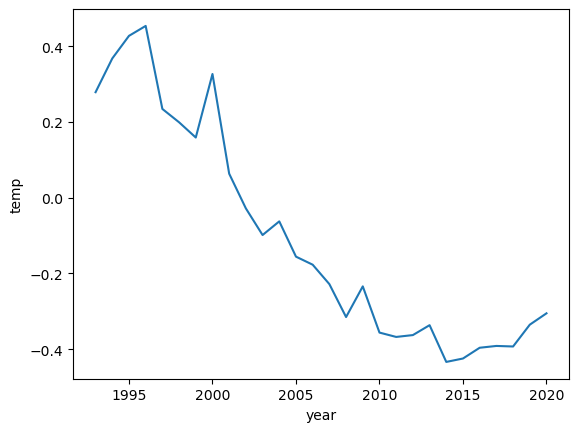

In [85]:
ds.where(EAST).temp.mean('trajectory').groupby('time.year').mean(dim='time').plot() # in 2008, what's the mean temp of all the trajectories going 

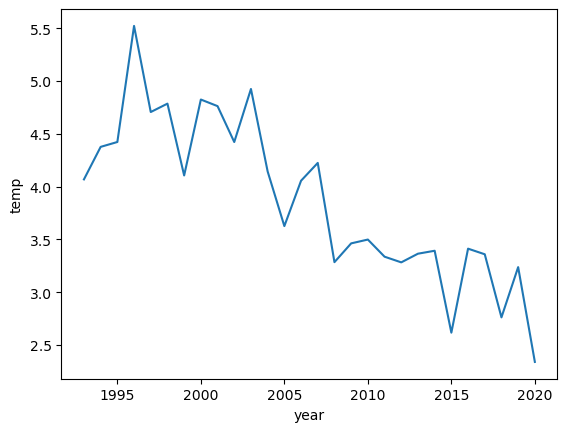

In [92]:
ds.where(EAST).where(ds.z < 500).temp.mean('trajectory').groupby('time.year').mean(dim='time').plot() # in 2008, what's the mean temp of all the trajectories going 


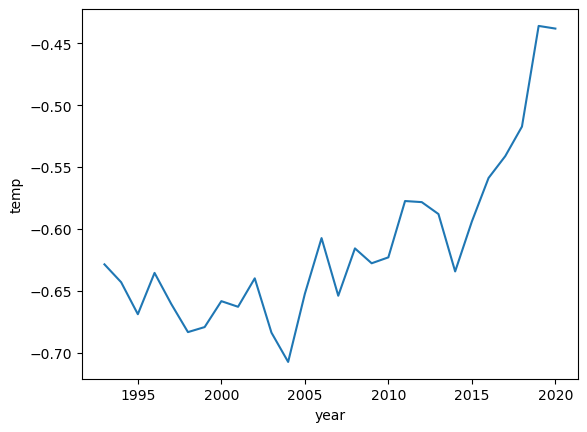

In [93]:
ds.where(EAST).where(ds.z > 600).temp.mean('trajectory').groupby('time.year').mean(dim='time').plot()

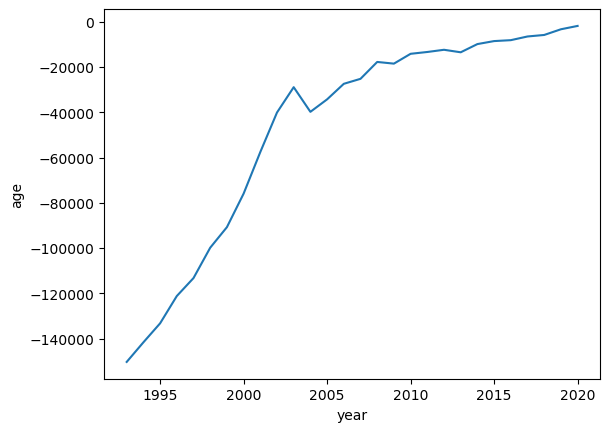

In [116]:

ds_sigma_thresh.where(EAST).age.mean('trajectory').groupby('time.year').mean(dim='time').plot() # in 2008, what's the mean age of all the trajectories going 

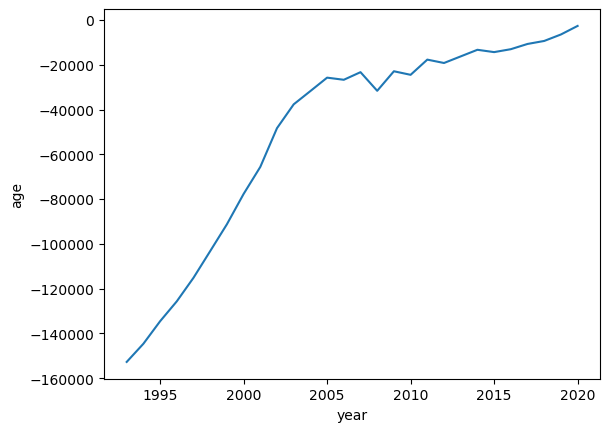

In [117]:

ds_sigma_thresh.where(WEST).age.mean('trajectory').groupby('time.year').mean(dim='time').plot() # in 2008, what's the mean temp of all the trajectories going 

In [ ]:
#

In [102]:
ds_one_file = xr.open_dataset('data/level2/parcels_releases_seed-2345.zarr', engine='zarr', chunks='auto')


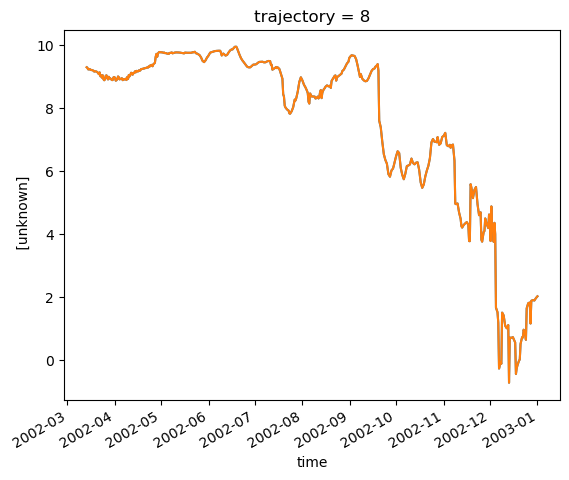

In [113]:
plt.plot(ds_one_file.sel(trajectory=8).time, ds_one_file.sel(trajectory=8).temp)
ds.sel(trajectory=8).temp.plot()

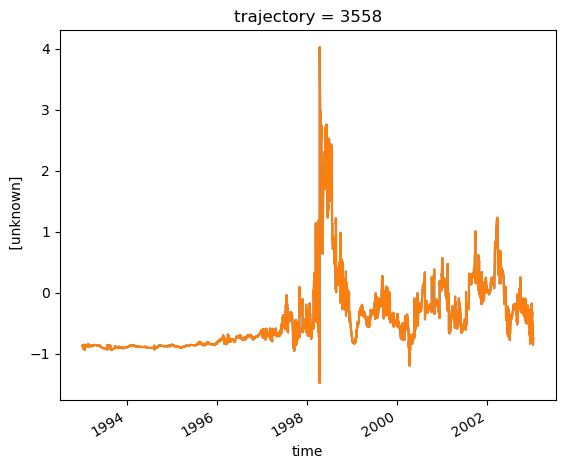

In [115]:
plt.plot(ds_one_file.isel(trajectory=1000).time, ds_one_file.isel(trajectory=1000).temp)
ds.isel(trajectory=1000).temp.plot()